# Error Distribution Identification

For this exercise we are going to simulate different time series using various functional forms for the deterministic term and using a normal noise term. Then, we fit a simple dense neural network in order to fit the model to the data and then recover the error distribution.

Before proceeding, we import the necessary modules and packages:

In [87]:
# Own Modules

from TimeSeries.utils import *
from NeuralNetworks.classes import *

# Other modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.stats.stattools import jarque_bera
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras

**Polynomial Deterministic Term**

First, we simulate the time series with a normal error term and the desired deterministic term. In this case, the time series will be a function of the form:

$$f(t)=2t^2+3t+5+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{N}(0,40n)$$

and $n$ is the number of observations (used to scale the standard deviation).

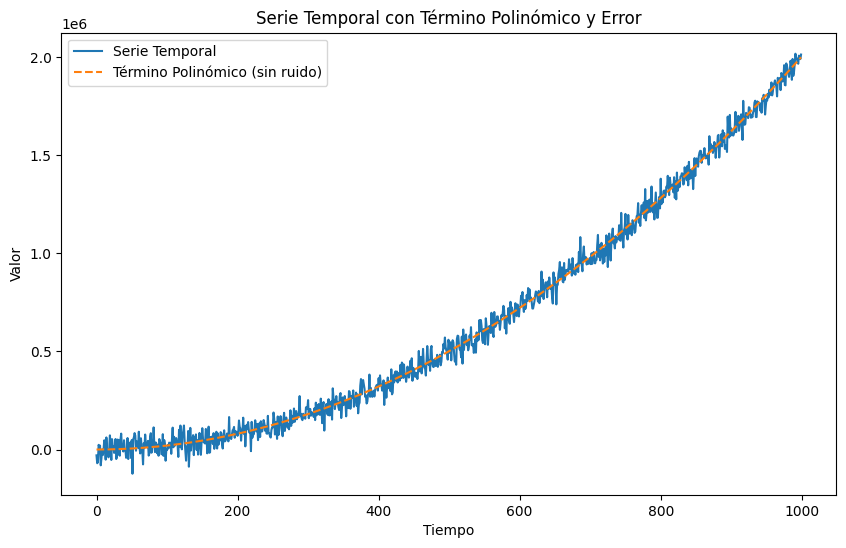

In [88]:
n = 1000
params = [5, 3, 2]

series_list = []

for i in range(0, n):
    determ_term = polinomForm(params, i)
    random_term = np.random.normal(0, 40*n, 1)[0]
    value = determ_term + random_term
    series_list.append(value)

series = pd.DataFrame(series_list, columns=["Value"])

plt.figure(figsize=(10, 6))
plt.plot(series.index, series['Value'], label='Serie Temporal')
plt.plot(series.index, [polinomForm(params, i) for i in range(n)], label='Término Polinómico (sin ruido)', linestyle='--')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie Temporal con Término Polinómico y Error')
plt.legend()
plt.show()

Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and a MSE loss function, evaluating the results through the MAE.

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0217 - mae: 0.0874
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7318e-04 - mae: 0.0192
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2515e-04 - mae: 0.0200
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9161e-04 - mae: 0.0194
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1079e-04 - mae: 0.0193
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4513e-04 - mae: 0.0202
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8110e-04 - mae: 0.0176
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2584e-04 - mae: 0.0184
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5268e-04 - mae: 0.0187
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6109e-04 - mae: 0.0218
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9172e-04 - mae: 0.0193
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7365e-04 - mae: 0.0208
Epoch 13/50
62/6

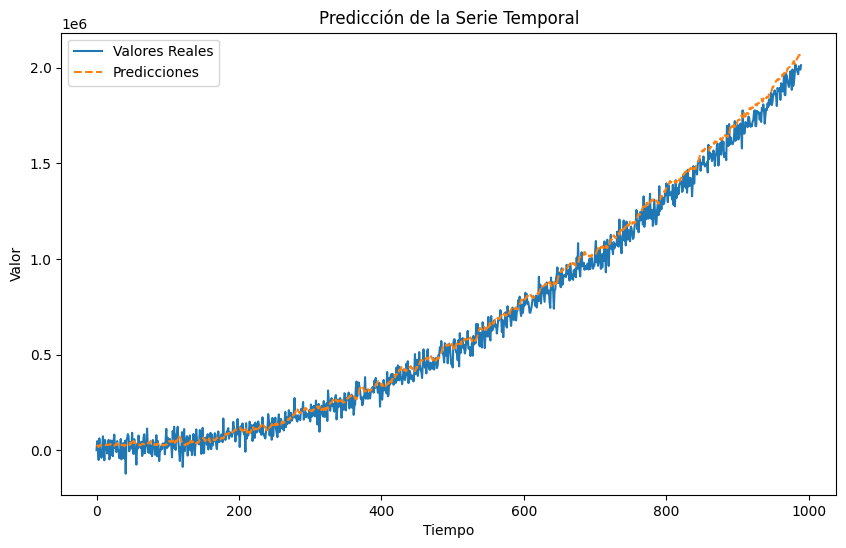

In [89]:
scaler = MinMaxScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 10
data = series["Value"].values
x, y = create_sequences(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)

nn_handler.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="mse",
    metrics=["mae"],
    n_batches=1
)

nn_handler.train(
    train_x=x,
    train_y=y,
    batch_size=16,
    epochs=50,
    shuffle=True,
    callback=None,
    y_weights=None,
    x_weights=None,
    opt_hyp=False
)

loss = nn_handler.evaluate(
    train_x=x,
    train_y=y,
    batch_size=16,
    x_weights=None,
    callbacks=None
)
print(f"Resultados de la evaluación: {loss}")

predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
predicted_values = np.array(predictions["pred"])

y_test = scaler.inverse_transform(y.reshape(-1, 1))
predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores Reales")
plt.plot(predicted_values, label="Predicciones", linestyle="--")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.title("Predicción de la Serie Temporal")
plt.legend()
plt.show()

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Mean: -27186.260835114168
Standard Dev.: 46188.18850907854
Skew: 0.034024658832744664
Kurtosis: 2.804507341299669
Max: 105041.78971986705
Min: -166931.96311771823
Jarque-Bera Stat: 1.7674836811690886 | p-value: 0.41323376029516024




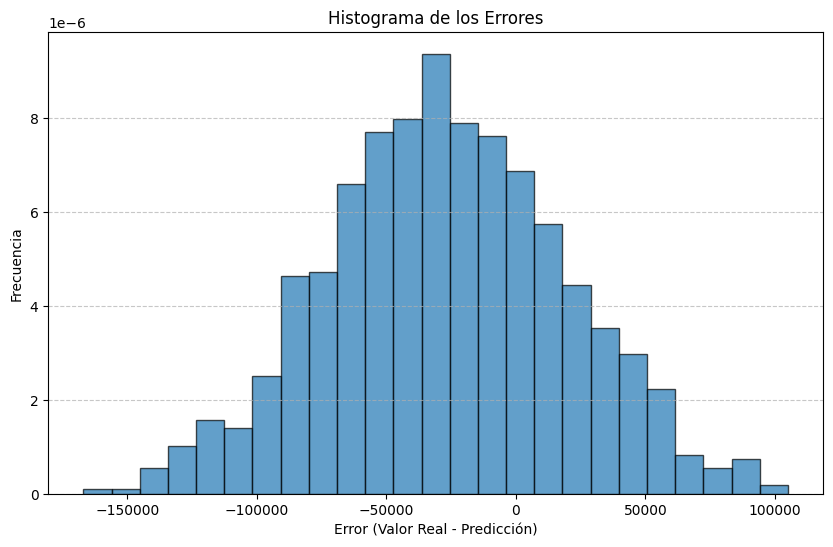

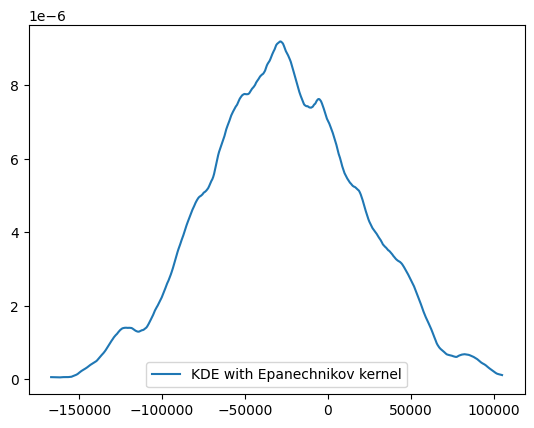

In [90]:
errors = y_test.flatten() - predicted_values.flatten()

stat, p_value, skew, kurtosis = jarque_bera(errors)

print(f"Mean: {errors.mean()}")
print(f"Standard Dev.: {errors.std()}")
print(f"Skew: {skew}")
print(f"Kurtosis: {kurtosis}")
print(f"Max: {errors.max()}")
print(f"Min: {errors.min()}")
print(f"Jarque-Bera Stat: {stat} | p-value: {p_value}")
print("\n")

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25, edgecolor='k', alpha=0.7, density=True)
plt.xlabel("Error (Valor Real - Predicción)")
plt.ylabel("Frecuencia")
plt.title("Histograma de los Errores")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

kde = KDEUnivariate(errors)
bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
kde.fit(kernel='epa', bw=bw, fft=False)
x = np.linspace(min(errors), max(errors), n)
y = [kde.evaluate(val).item() for val in x]

plt.plot(x, y, label="KDE with Epanechnikov kernel")
plt.legend()
plt.show()

**Sinusoidal Deterministic Term**

First, we simulate the time series with a normal error term and the desired deterministic term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.25t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{N}(0,2)$$

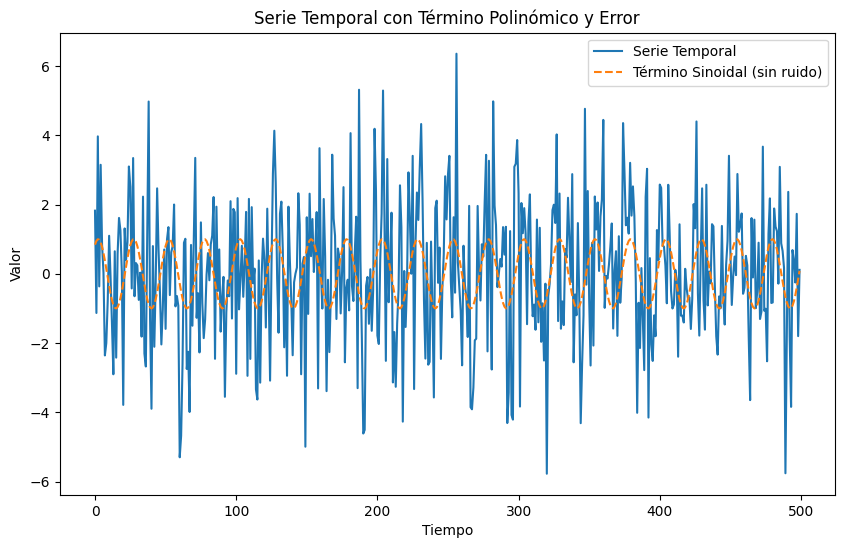

In [91]:
n = 500
params = {"A": 1,"B":0.25,"C":1}

series_list = []

for i in range(0, n):
    value = sinForm(params, i)+np.random.normal(0, 2, 1)[0]
    series_list.append(value)

series = pd.DataFrame(series_list, columns=["Value"])

plt.figure(figsize=(10, 6))
plt.plot(series.index, series['Value'], label='Serie Temporal')
plt.plot(series.index, [sinForm(params, i) for i in range(n)], label='Término Sinoidal (sin ruido)', linestyle='--')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie Temporal con Término Polinómico y Error')
plt.legend()
plt.show()

Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and a MSE loss function, evaluating the results through the MAE.

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1370 - mae: 0.2842
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301 - mae: 0.1406
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 - mae: 0.1385
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0314 - mae: 0.1423
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284 - mae: 0.1339
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294 - mae: 0.1386
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290 - mae: 0.1402
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0280 - mae: 0.1328
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0265 - mae: 0.1288
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301 - mae: 0.1365
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0280 - mae: 0.1352
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 - mae: 0.1331
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0

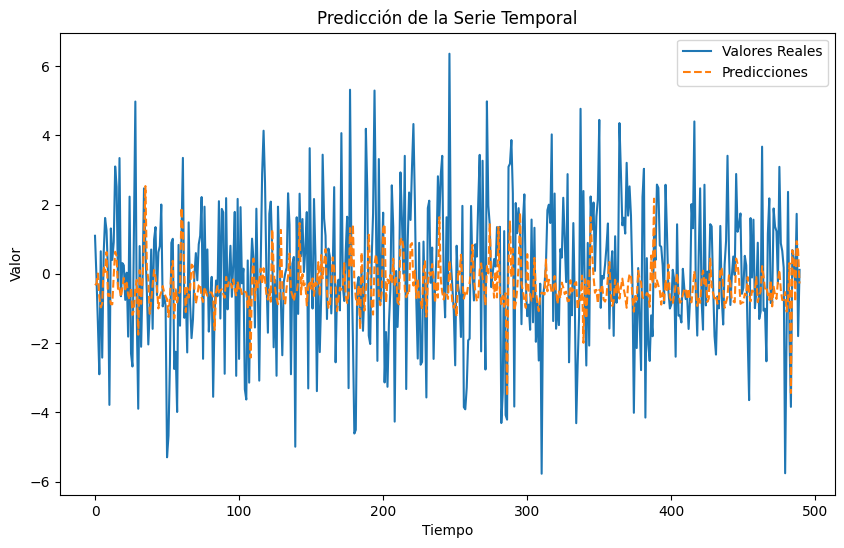

In [92]:
scaler = MinMaxScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 10
data = series["Value"].values
x, y = create_sequences(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)

nn_handler.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="mse",
    metrics=["mae"],
    n_batches=1
)

nn_handler.train(
    train_x=x,
    train_y=y,
    batch_size=16,
    epochs=50,
    shuffle=True,
    callback=None,
    y_weights=None,
    x_weights=None,
    opt_hyp=False
)

loss = nn_handler.evaluate(
    train_x=x,
    train_y=y,
    batch_size=16,
    x_weights=None,
    callbacks=None
)
print(f"Resultados de la evaluación: {loss}")

predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
predicted_values = np.array(predictions["pred"])

y_test = scaler.inverse_transform(y.reshape(-1, 1))
predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores Reales")
plt.plot(predicted_values, label="Predicciones", linestyle="--")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.title("Predicción de la Serie Temporal")
plt.legend()
plt.show()

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Mean: 0.37906283061094864
Standard Dev.: 1.9488564684913265
Skew: -0.03812745312945459
Kurtosis: 2.9584803123785357
Max: 5.970346679980183
Min: -5.226843175749489
Jarque-Bera Stat: 0.15391502677008798 | p-value: 0.9259291923678767




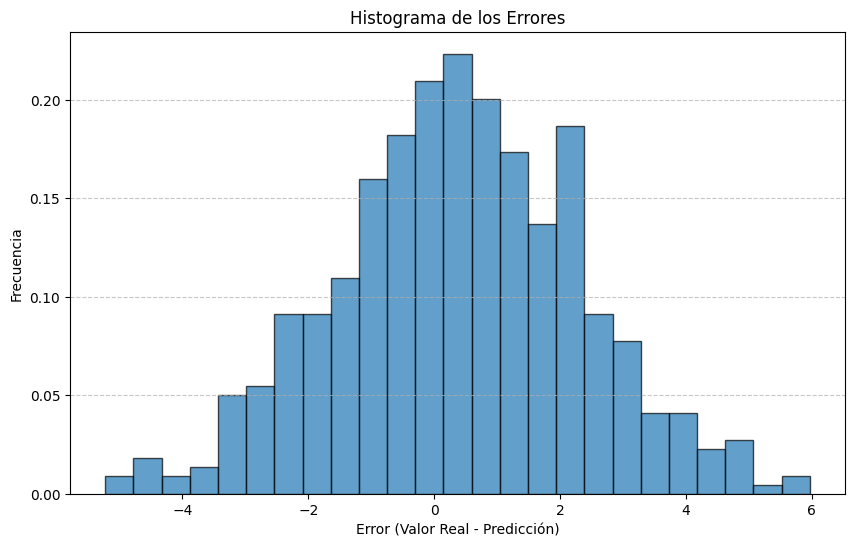

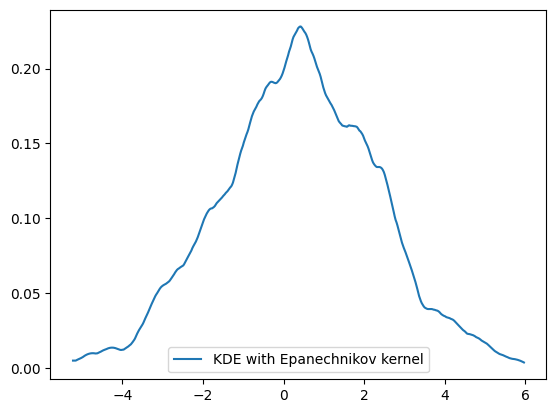

In [93]:
errors = y_test.flatten() - predicted_values.flatten()

stat, p_value, skew, kurtosis = jarque_bera(errors)

print(f"Mean: {errors.mean()}")
print(f"Standard Dev.: {errors.std()}")
print(f"Skew: {skew}")
print(f"Kurtosis: {kurtosis}")
print(f"Max: {errors.max()}")
print(f"Min: {errors.min()}")
print(f"Jarque-Bera Stat: {stat} | p-value: {p_value}")
print("\n")

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25, edgecolor='k', alpha=0.7, density=True)
plt.xlabel("Error (Valor Real - Predicción)")
plt.ylabel("Frecuencia")
plt.title("Histograma de los Errores")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

kde = KDEUnivariate(errors)
bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
kde.fit(kernel='epa', bw=bw, fft=False)
x = np.linspace(min(errors), max(errors), n)
y = [kde.evaluate(val).item() for val in x]

plt.plot(x, y, label="KDE with Epanechnikov kernel")
plt.legend()
plt.show()